In [22]:
# Install facenet-pytorch
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl

from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p $torch_home/checkpoints/
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth $torch_home/checkpoints/vggface2_DG3kwML46X.pt
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth $torch_home/checkpoints/vggface2_G5aNV2VSMn.pt

Processing /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.7-py3-none-any.whl
facenet-pytorch is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


## Importing Required Libraries

The necessary libraries and modules are imported, including:

In [23]:
import os
import argparse
import joblib
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
import joblib
import random
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import torch
from sklearn.decomposition import PCA
from sklearn import svm

## Utility Functions

The following utility functions are defined:

* **whitens(img):** Performs image whitening by subtracting the mean and dividing by the standard deviation of the image.
* **extract_features(mtcnn, facenet, img):** Extracts facial features from an image using the MTCNN face detection and the InceptionResnetV1 model. Returns the bounding boxes and embeddings of detected faces.
* **dataset_to_embeddings(dataset, mtcnn, facenet):** Converts a dataset of images into a list of embeddings and labels using the MTCNN and InceptionResnetV1 models.
* **train(embeddings, labels):** Train the embeddings and labels using SVM Model with True probability

In [24]:
def whitens(img):
        mean = img.mean()
        std = img.std()
        std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
        y = (img - mean) / std_adj
        return y
    
def extract_features(mtcnn, facenet, img):
        img = img.to(device)
        img = transforms.ToPILImage()(img.squeeze_(0))
        bbs, _ = mtcnn.detect(img)
        if bbs is None:
            # if no face is detected
            return None, None

        faces = torch.stack([extract_face(img, bb) for bb in bbs])
        embeddings = facenet(whitens(faces)).detach().numpy()

        return bbs, embeddings
    
def dataset_to_embeddings(dataset, mtcnn, facenet):
    transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])

    embeddings = []
    labels = []
    for img_path, label in dataset.samples:
        print(img_path)
        
        _, embedding = extract_features(mtcnn, facenet, transform(Image.open(img_path).convert('RGB')).unsqueeze_(0))
        if embedding is None:
            print("Could not find face on {}".format(img_path))
            continue
        if embedding.shape[0] > 1:
            print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
            embedding = embedding[0, :]
        embeddings.append(embedding.flatten())
        labels.append(label)

    return np.stack(embeddings), labels

def train(embeddings, labels):
    clf = svm.SVC(probability=True)
    clf.fit(embeddings, labels)
    return clf

## Model Initialization
The code initializes the MTCNN and InceptionResnetV1 models for face detection and feature extraction, respectively:

**Note:** Cuda implementation is not working here. But it is working well in local system.

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device='cpu'

mtcnn = MTCNN(keep_all=True, thresholds=[0.6, 0.7, 0.9], device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()

facenet = facenet.to(device)

## Dataset Preparation
The code defines the path to the dataset folder and creates ImageFolder datasets for training and validation:

In [26]:
# Define the path to your dataset folder
data_path = "/kaggle/input/vietnam-singer"

# Create the ImageFolder dataset
dataset_train = datasets.ImageFolder(root="/kaggle/input/vietnam-singer/CA SI VIET NAM/train")
dataset_val = datasets.ImageFolder(root="/kaggle/input/vietnam-singer/CA SI VIET NAM/val")

## Generating Embeddings
The code generates embeddings and labels for the training and validation datasets using the dataset_to_embeddings function:

In [27]:
X_train, y_train = dataset_to_embeddings(dataset_train, mtcnn, facenet)
X_test, y_test = dataset_to_embeddings(dataset_val, mtcnn, facenet)
    
X_train_class_idx = dataset_train.class_to_idx
X_test_class_idx = dataset_val.class_to_idx

embeddings, labels, class_to_idx = X_train, y_train, X_train_class_idx

/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287143381000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287203622000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287324922000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287352370000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287396146000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287456944000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287544243000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287592706000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287726823000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287794239000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM/train/bui anh tuan/1671998287867744000.jpg
/kaggle/input/vietnam-singer/CA SI VIET NAM

## Training
The code trains a classification model using the training embeddings and labels:

In [28]:
clf = train(embeddings, labels)
    
# Save the trained model
joblib.dump(clf, 'face_recognition_model.pkl')

['face_recognition_model.pkl']

## Model Evaluation
The code evaluates the trained model by printing a classification report and calculating the accuracy on the validation set:

In [29]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(labels, clf.predict(embeddings), target_names=target_names))

# Predict labels for validation set and calculate accuracy
y_val_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_val_pred)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

{0: 'bui anh tuan', 1: 'ha anh tuan', 2: 'ho ngoc ha', 3: 'soobin hoang son'}
                  precision    recall  f1-score   support

    bui anh tuan       1.00      1.00      1.00        34
     ha anh tuan       1.00      1.00      1.00        42
      ho ngoc ha       1.00      1.00      1.00        39
soobin hoang son       1.00      1.00      1.00        40

        accuracy                           1.00       155
       macro avg       1.00      1.00      1.00       155
    weighted avg       1.00      1.00      1.00       155

Validation Accuracy: 100.00%


## Visualization
The code visualizes the embeddings in a 2D space using PCA and plots a scatter plot with colored points representing different classes:

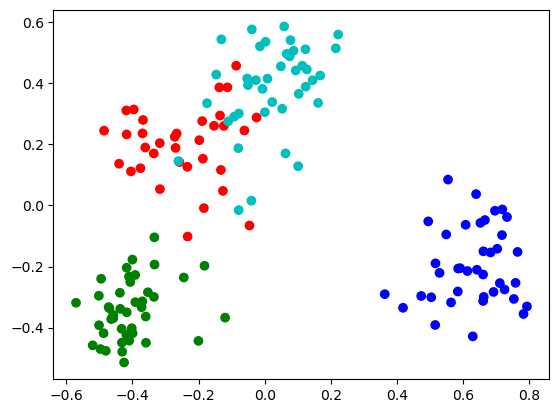

In [30]:
# Use PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=5)
embeddings_2d = pca.fit_transform(X_train)  # replace X_train with your embeddings

# Map numeric labels to actual names
mapped_labels = [idx_to_class[label] for label in y_train]  # replace y_train with your labels

# Define a function to assign colors to labels
def assign_colors(label):
    colors = {'bui anh tuan': 'r', 'ha anh tuan': 'g', 'ho ngoc ha': 'b', 'soobin hoang son': 'c'}
    return colors[label]

# Create color array for all points
colors = list(map(assign_colors, mapped_labels))

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
plt.show()

## Face Recognition

The code performs face recognition on randomly selected images from the validation set. It predicts the labels for the images and displays the predicted and actual labels along with the image:

[[0.0465984  0.01037237 0.01760507 0.92542416]]


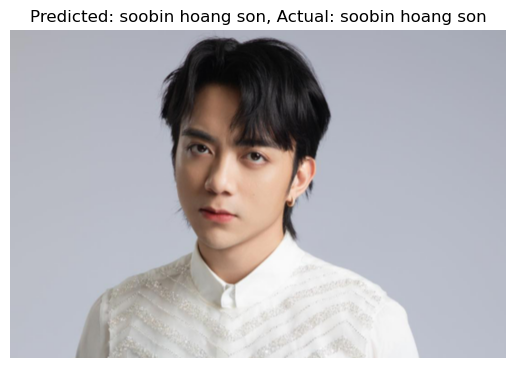

[[0.0465984  0.01037237 0.01760507 0.92542416]]


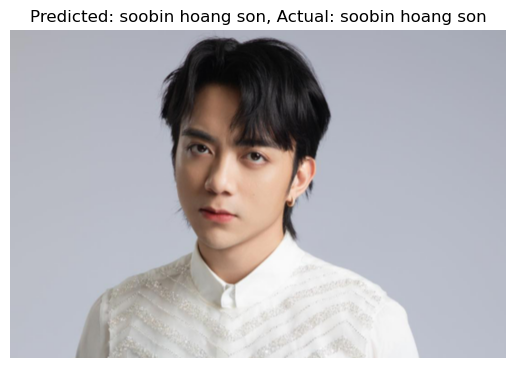

[[0.00396572 0.0037157  0.98515544 0.00716315]]


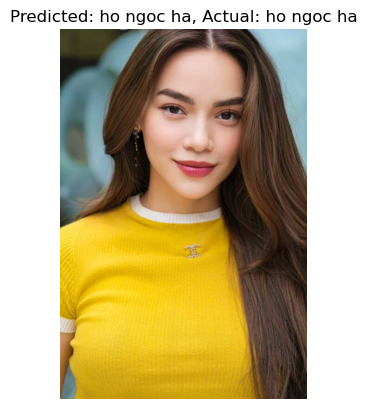

[[0.96785253 0.00337326 0.0039647  0.02480951]]


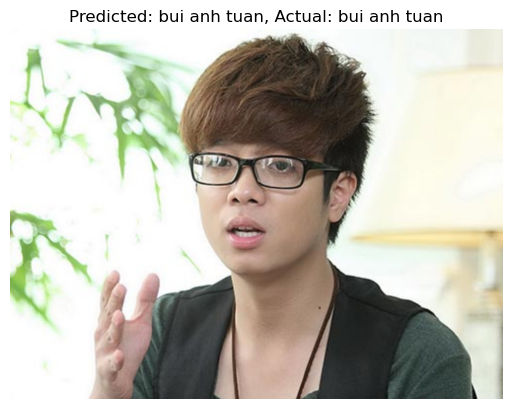

[[0.0465984  0.01037237 0.01760507 0.92542416]]


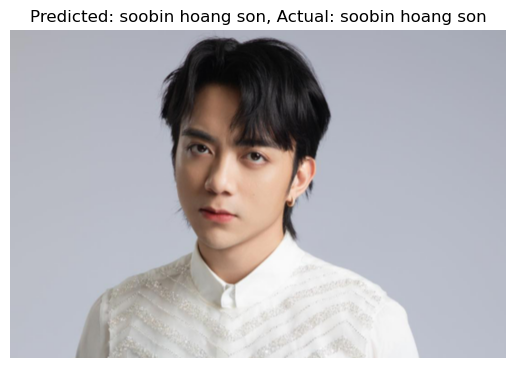

In [31]:
# Image transformations
transform_img = transforms.Compose([transforms.Resize(1024)])
transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])


# Load the validation dataset
dataset_val = datasets.ImageFolder(root="/kaggle/input/vietnam-singer/CA SI VIET NAM/val")
val_samples = dataset_val.samples

# Randomly select 5 images from the validation set
random_samples = random.choices(val_samples, k=5 )

for img_path, true_label in random_samples:
    # Load and transform the image
    img_ = transform_img(Image.open(img_path).convert('RGB'))
    img = transform(Image.open(img_path).convert('RGB'))

    # Extract features
    _, embedding = extract_features(mtcnn, facenet, img)
    if embedding is None:
        print("Could not find face on {}".format(img_path))
        continue
    if embedding.shape[0] > 1:
        print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
        embedding = embedding[0, :]

    # Predict the label
    predicted_label = clf.predict(embedding.reshape(1, -1))
    print(clf.predict_proba(embedding))
    # Convert label indexes back to original classes
    predicted_class = idx_to_class[predicted_label[0]]
    true_class = idx_to_class[true_label]
    # Plot image with predicted and actual labels
    plt.imshow(img_)
    plt.title(f'Predicted: {predicted_class}, Actual: {true_class}')
    plt.axis('off')
    plt.show()

## Intruder Recognition

The code performs face recognition on a single image specified by img_path and displays the predicted label along with the image:

In [32]:
img_path = '/kaggle/input/savan-face/savan-agrawal.png'

img_ = transform_img(Image.open(img_path).convert('RGB'))
img = transform(Image.open(img_path).convert('RGB'))
_, embedding = extract_features(mtcnn, facenet, img)

predicted_label = clf.predict(embedding.reshape(1, -1))
# Convert label indexes back to original classes
predicted_class = idx_to_class[predicted_label[0]]
true_class = idx_to_class[true_label]
print((clf.predict_proba(embedding)))
thres = 0.6
if np.max(clf.predict_proba(embedding)) < thres:
    predicted_class = 'Intruder'

# Plot image with predicted and actual labels
plt.imshow(img_)
plt.title(f'Predicted: {predicted_class}, Actual: {"Savan Agrawal"}')
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/savan-face/savan-agrawal.png'